# Лабораторная работа №6
**Студент**: Суханов Е.А.

**Группа**: М8О-406Б-19

**Задание**: Используя явную схему крест и неявную схему, решить начально-краевую задачу для дифференциального уравнения гиперболического типа. Аппроксимацию второго начального условия произвести с первым и со вторым порядком. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением . Исследовать зависимость погрешности от сеточных параметров .

**Вариант**: 7

In [141]:
import numpy as np
import matplotlib.pyplot as plt

In [142]:
class Task():
    def __init__(self, u0, u0t, ul, l, ur, r, f, a, b, c, d):
        self.u0 = u0
        self.u0t = u0t
        self.ul = ul
        self.l = l
        self.ur = ur
        self.r = r
        self.f = f
        self.a = a
        self.b = b
        self.c = c
        self.d = d

# Вариант 7
task = Task(
    u0=lambda x: np.exp(-x)*np.cos(x),
    u0t=lambda x: -np.exp(-x)*np.cos(x),
    ul=lambda t: np.exp(-t)*np.cos(2*t),
    l=0,
    ur=lambda t: 0,
    r=np.pi/2,
    f=lambda x,t: 0,
    a=1,
    b=2,
    c=-3,
    d=2,
)

analytic_func = lambda x,t: np.exp(-t-x)*np.cos(x)*np.cos(2*t)

T_RES = 1000
H_RES = 40
END_TIME = 4

In [143]:
# Аналитическое решение
def analytic(l_bound, r_bound, func, end_time, t_res, h_res):
    h = (r_bound - l_bound) / h_res
    tau = end_time / t_res
    u = np.zeros(shape=(t_res, h_res))

    for t_itr in range(0, t_res):
        for x in range(0, h_res):
            u[t_itr][x] = func(l_bound + x * h, t_itr * tau)
    
    return u

In [144]:
analytic_nodes = analytic(task.l, task.r, analytic_func, END_TIME, T_RES, H_RES)
print(analytic_nodes)

[[ 1.00000000e+00  9.60749885e-01  9.21615433e-01 ...  2.74885611e-02
   1.76426789e-02  8.48818399e-03]
 [ 9.95976117e-01  9.56883940e-01  9.17906960e-01 ...  2.73779503e-02
   1.75716868e-02  8.45402853e-03]
 [ 9.91904937e-01  9.52972555e-01  9.14154898e-01 ...  2.72660394e-02
   1.74998603e-02  8.41947161e-03]
 ...
 [-2.25621567e-03 -2.16765895e-03 -2.07936318e-03 ... -6.20201223e-05
  -3.98056887e-05 -1.91511737e-05]
 [-2.39373921e-03 -2.29978467e-03 -2.20610700e-03 ... -6.58004464e-05
  -4.22319723e-05 -2.03184988e-05]
 [-2.52997621e-03 -2.43067435e-03 -2.33166512e-03 ... -6.95454056e-05
  -4.46355580e-05 -2.14749036e-05]]


In [145]:
# Численное вычисление первой производной
def num_der_1(f,x,h):
    return (f(x + h) - f(x - h))/(2*h) 

# Численное вычисление второй производной
def num_der_2(f,x,h):
    return (f(x - h) - 2*f(x) + f(x + h))/(h**2) 

# Инициализация первых двух слоев сетки
def init_grid(task: Task, end_time, t_res, h_res, approx = '1p2'):
    h = (task.r - task.l) / h_res
    tau = end_time / t_res
    u = np.zeros((t_res, h_res))

    for j in range(0, h_res - 1):
        x = j * h + task.l
        u[0][j] = task.u0(x)

        if approx == '1p2': # двухточечная первого поряда
            u[1][j] = u[0][j] + task.u0t(x)*tau
        elif approx == '2p2': # двухточечная второго порядка
            u[1][j] = u[0][j] + task.u0t(x)*tau + task.a*num_der_1(task.u0t, x, h) * (tau ** 2) / 2
    return u

In [146]:
# Явная схема   
def explicit(task: Task, end_time, t_res, h_res, init_approx='1p2', approx='c'):
    h = (task.r - task.l) / h_res
    tau = end_time / t_res
    sigma = (task.a * tau**2)/(h**2)

    if sigma > 1:
        raise ValueError(f"Sigma: {sigma}")

    u = init_grid(task, end_time, t_res, h_res, approx=init_approx)
    for k in range(t_res):
        u[k,0] = task.ul(k*tau)
        u[k,-1] = task.ur(k*tau)

    for k in range(2, t_res):
        for j in range(1, h_res - 1):
            x = task.l + j * h
            u[k][j] = task.a*(tau**2)/(h**2)*(u[k-1][j-1] - 2*u[k-1][j] + u[k-1][j+1])
            u[k][j] += task.b*(tau**2)/(2*h)*(u[k-1][j+1] - u[k-1][j-1])
            u[k][j] += task.c*(tau**2)*(u[k-1][j])
            u[k][j] += (tau**2)*task.f(x, k * tau)
            
            if approx == 'c': # центральная аппроксимация первой производной по времени
                u[k][j] += -(1/2)*(-4*u[k-1][j] + 2*u[k-2][j] - task.d*tau*u[k-2][j]) * 2/(2 + task.d*tau)
            elif approx == 't': #хвостовая аппроксимация первой производной по времени
                u[k][j] += 2*u[k-1][j] - u[k-2][j] - task.d*tau*(u[k-1][j] - u[k-2][j])

    return u

In [147]:
explicit_nodes = explicit(task, END_TIME, T_RES, H_RES)
print(explicit_nodes)

[[ 1.00000000e+00  9.60749885e-01  9.21615433e-01 ...  2.74885611e-02
   1.76426789e-02  0.00000000e+00]
 [ 9.95976117e-01  9.56906885e-01  9.17928971e-01 ...  2.73786068e-02
   1.75721082e-02  0.00000000e+00]
 [ 9.91904937e-01  9.53017724e-01  9.14198455e-01 ...  2.72673348e-02
   1.74095308e-02  0.00000000e+00]
 ...
 [-2.25621567e-03 -2.18113315e-03 -2.08726838e-03 ... -4.08614983e-05
  -3.68602389e-05  0.00000000e+00]
 [-2.39373921e-03 -2.30821191e-03 -2.21889503e-03 ... -4.39024223e-05
  -3.99408648e-05  0.00000000e+00]
 [-2.52997621e-03 -2.43405675e-03 -2.34929101e-03 ... -4.67683590e-05
  -4.26038435e-05  0.00000000e+00]]


In [148]:
# Метод прогонки
def tridiagonal_matrix_algorithm(a, b, c, d):
    n = len(a)

    p = np.zeros(n)
    q = np.zeros(n)

    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, n):
        p[i] = -c[i] / (b[i] + a[i] * p[i - 1])
        q[i] = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])

    x = np.zeros(n)
    x[-1] = q[-1]

    for i in range(n - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]

    return x

# Неявная схема
def implicit(task: Task, end_time, t_res, h_res, init_approx='1p2'):
    h = (task.r - task.l) / h_res
    tau = end_time / t_res
    sigma = (task.a * tau)/(h**2)

    a = np.zeros(h_res)
    b = np.zeros(h_res)
    c = np.zeros(h_res)
    d = np.zeros(h_res)
    u = init_grid(task, end_time, t_res, h_res, init_approx)
    for k in range(t_res):
        u[k,0] = task.ul(k*tau)
        u[k,-1] = task.ur(k*tau)

    for k in range(2, t_res):
        for j in range(1, h_res-1):
            a[j] = -((task.a / (h**2)) - (task.b / (2*h)))
            b[j] = (1/(tau**2) + task.d/tau + ((2*task.a) / (h**2)) - task.c)
            c[j] = -((task.a / (h**2)) + (task.b / (2*h)))
            d[j] = (2*u[k-1][j] - u[k-2][j])/(tau**2) + task.d * u[k-1][j]/tau + task.f(task.l + j * h, k * tau)

        a[0] = 0
        b[0] = 1
        c[0] = 0
        d[0] = u[k][0]
        a[-1] = 0
        b[-1] = 1
        c[-1] = 0
        d[-1] = u[k][-1]

        u[k] = tridiagonal_matrix_algorithm(a, b, c, d)

    return u

In [149]:
implicit_nodes = implicit(task, END_TIME, T_RES, H_RES)
print(implicit_nodes)

[[ 1.00000000e+00  9.60749885e-01  9.21615433e-01 ...  2.74885611e-02
   1.76426789e-02  0.00000000e+00]
 [ 9.95976117e-01  9.56906885e-01  9.17928971e-01 ...  2.73786068e-02
   1.75721082e-02  0.00000000e+00]
 [ 9.91904937e-01  9.53018291e-01  9.14199213e-01 ...  2.72664325e-02
   1.74124484e-02  0.00000000e+00]
 ...
 [-2.25621567e-03 -2.15682177e-03 -2.05913587e-03 ... -2.88966782e-05
  -1.38309369e-05  0.00000000e+00]
 [-2.39373921e-03 -2.28881616e-03 -2.18561981e-03 ... -3.12767925e-05
  -1.49764677e-05  0.00000000e+00]
 [-2.52997621e-03 -2.41957718e-03 -2.31092335e-03 ... -3.36380349e-05
  -1.61130756e-05  0.00000000e+00]]


#### Сравнение методов

In [150]:
# Вывод графика ошибки
def draw_error(analytic, t_end, numericals, suffix_labels):

    t_res = analytic.shape[0]
    t = np.arange(0, t_end, t_end/t_res)
    for n,l in zip(numericals, suffix_labels):
        err = np.max(np.abs(analytic - n), axis=1)
        print(f"mean err {l}: {np.mean(err)}")
        plt.plot(t, err, label = f'Ошибка {l}')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.title('График изменения ошибки во времени')
    plt.xlabel('t')
    plt.ylabel('error')
    plt.grid(True)
    plt.show()

mean err explicit 1p2: 0.004508016375527561
mean err explicit 2p2: 0.0044663118141012636
mean err explicit 1p2 t: 0.004317638190492514
mean err explicit 2p2 t: 0.004275390568327958
mean err implicit 1p2: 0.0031138072321226433
mean err implicit 2p2: 0.0030720231212258754


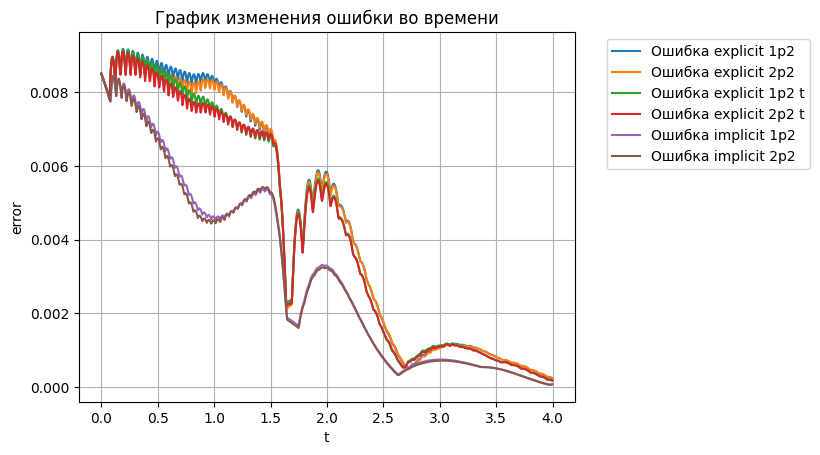

In [151]:
explicit_nodes_12 = explicit(task, END_TIME, T_RES, H_RES, init_approx='1p2')
explicit_nodes_22 = explicit(task, END_TIME, T_RES, H_RES, init_approx='2p2')
explicit_nodes_12_t = explicit(task, END_TIME, T_RES, H_RES, init_approx='1p2', approx='t')
explicit_nodes_22_t = explicit(task, END_TIME, T_RES, H_RES, init_approx='2p2', approx='t')

implicit_nodes_11 = implicit(task, END_TIME, T_RES, H_RES, init_approx='1p2')
implicit_nodes_12 = implicit(task, END_TIME, T_RES, H_RES, init_approx='2p2')

draw_error(analytic_nodes,  END_TIME, [explicit_nodes_12, explicit_nodes_22,explicit_nodes_12_t,explicit_nodes_22_t, implicit_nodes_11, implicit_nodes_12], ['explicit 1p2', 'explicit 2p2', 'explicit 1p2 t', 'explicit 2p2 t', 'implicit 1p2', 'implicit 2p2'])

In [152]:
def draw_cmp_levels(analytic, a, b, end_time, curr_time, numericals, labels):
    t_res = analytic.shape[0]
    h_res = analytic.shape[1]

    h = (b - a) / h_res
    tau = end_time / t_res

    curr_t_idx = int(curr_time / tau)
    curr_time = curr_t_idx * tau
    
    x = np.arange(a, b, h)
    plt.plot(x, analytic[curr_t_idx], label = f'Линия уровня аналитического решения')
    for n,l in zip(numericals, labels):
        plt.plot(x, n[curr_t_idx], label = f'Линия уровня {l}')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.title(f'График линий уровня в момент времени t = {curr_time}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.grid(True)
    plt.show()

def draw_cmp_levels_helper(time):
    explicit_nodes = explicit(task, END_TIME, T_RES, H_RES, init_approx='2p2', approx='t')
    implicit_nodes = implicit(task, END_TIME, T_RES, H_RES, init_approx='2p2')
    draw_cmp_levels(analytic_nodes, task.l, task.r,  END_TIME, time, [explicit_nodes, implicit_nodes], ['явного метода', 'неявного метода'])

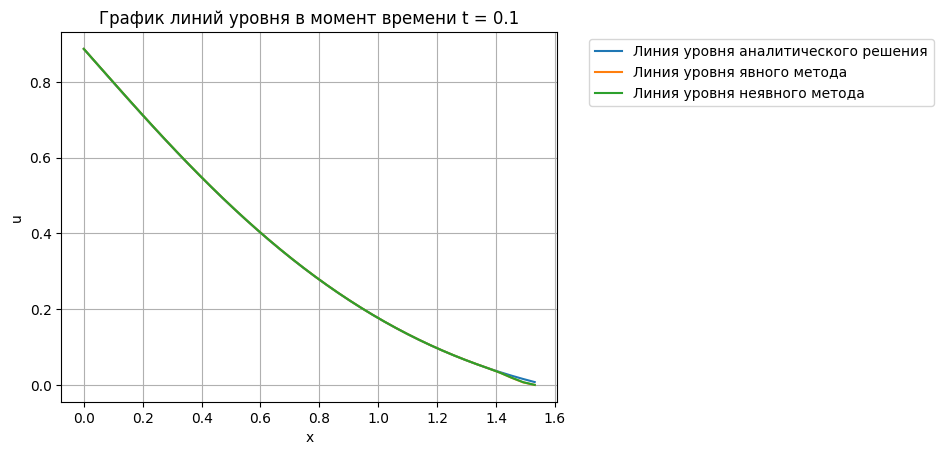

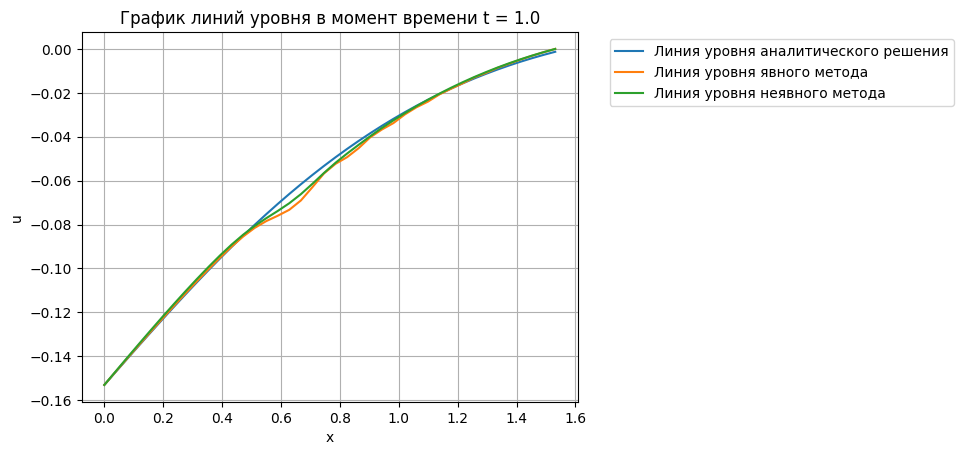

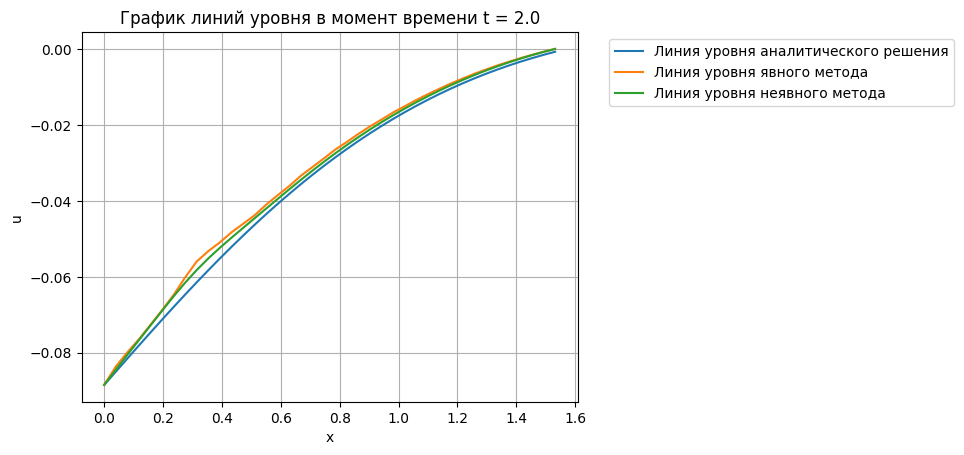

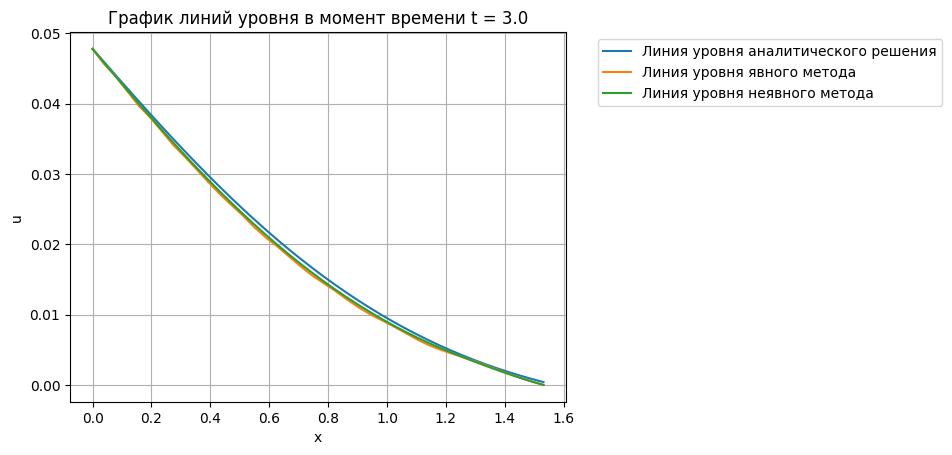

In [153]:
draw_cmp_levels_helper(0.1)
draw_cmp_levels_helper(1)
draw_cmp_levels_helper(2)
draw_cmp_levels_helper(3)

#### Исследование зависимости погрешности от сеточных параметров tau и h

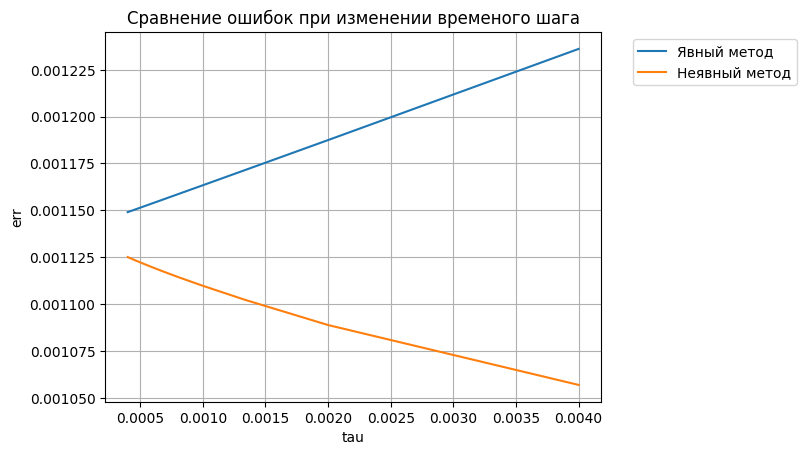

In [157]:
# Исследуем зависимость от tau при неизменном h
# tau зависит от t_res: чем больше t_res => тем меньше tau
H_RES = 40
T_RES_MIN = 1000
T_RES_MAX = 10000
T_RES_STEP = 1000
END_TIME = 4
t_res_list = [t_res for t_res in range(T_RES_MIN, T_RES_MAX + T_RES_STEP // 2, T_RES_STEP)]

tau_list = [END_TIME / t_res for t_res in t_res_list]
exp_v = []
imp_v = []
com_v = []
for t_res in t_res_list:
    analytic_nodes = analytic(task.l, task.r, analytic_func, END_TIME, t_res, H_RES)
    explicit_nodes = explicit(task, END_TIME, t_res, H_RES)
    implicit_nodes = implicit(task, END_TIME, t_res, H_RES)
    get_err = lambda nodes: (np.mean(np.abs(analytic_nodes - nodes)))
    exp_v.append(get_err(explicit_nodes))
    imp_v.append(get_err(implicit_nodes)) 

plt.plot(tau_list, exp_v, label = 'Явный метод')
plt.plot(tau_list, imp_v, label = 'Неявный метод')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.title(f'Сравнение ошибок при изменении временого шага')
plt.xlabel('tau')
plt.ylabel('err')
plt.grid(True)
plt.show()

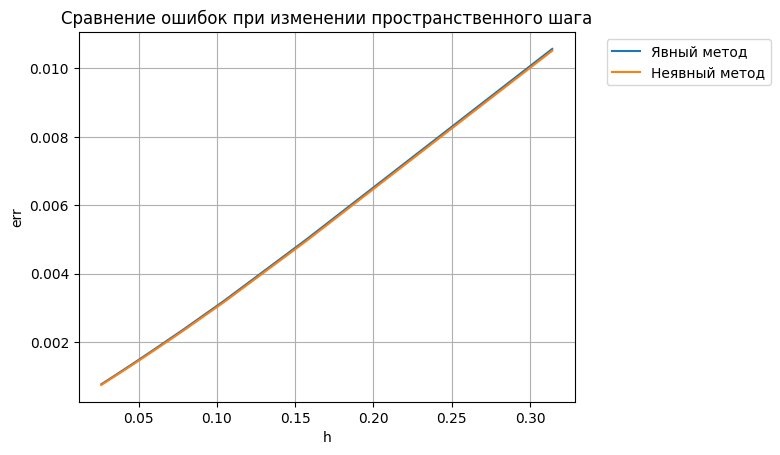

In [158]:
# Исследуем зависимость от h при неизменном tau
# h зависит от h_res: чем больше h_res => тем меньше h
T_RES = 10000
H_RES_MIN = 5
H_RES_MAX = 60
H_RES_STEP = 5
END_TIME = 4
h_res_list = [h_res for h_res in range(H_RES_MIN, H_RES_MAX + H_RES_STEP // 2, H_RES_STEP)]

h_list = [(task.r - task.l) / h_res for h_res in h_res_list]
exp_v = []
imp_v = []
com_v = []
for h_res in h_res_list:
    analytic_nodes = analytic(task.l, task.r, analytic_func, END_TIME, T_RES, h_res)
    explicit_nodes = explicit(task, END_TIME, T_RES, h_res)
    implicit_nodes = implicit(task, END_TIME, T_RES, h_res)
    get_err = lambda nodes: (np.mean(np.abs(analytic_nodes - nodes)))
    exp_v.append(get_err(explicit_nodes))
    imp_v.append(get_err(implicit_nodes)) 

plt.plot(h_list, exp_v, label = 'Явный метод')
plt.plot(h_list, imp_v, label = 'Неявный метод')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.title(f'Сравнение ошибок при изменении пространственного шага')
plt.xlabel('h')
plt.ylabel('err')
plt.grid(True)
plt.show()

#### Выводы

Неявная схема показывает меньшую ошибку при меланьком временном разрешении. Но при увеличении временного разрешения, ошибка явной схемы уменьшается, а неявной увеличивается.

При увеличении пространственного разрешения, ошибка обоих методов уменьшается.